In [8]:
# required all possible library
# 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from  sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import datetime 
sns.set_theme()


Training dataset loading --it is in csv format with total of there main sheets of data, train data linked with commodity id which is described in commodity data sheet which is basically items like wheet, rice, pulses and agriculture products.

This is dataset of related to agriculture field over period of time.
Inflation data sheet describing effect of inflation in minimum support or other prices. It is directly link with products.

Prediction of minimum support price.

main features of dataset are 
```Production weight, Labour_availability	,Govt_policy_change,	Demand,	Cost of production,	Climatic factor 1,	Climatic factor 2	,Maximum price per kg	,Minimum support price (in Rs./Quintal)```



In [16]:
train_path = "/content/drive/MyDrive/datasets/time-series-dataset/train.csv"
test_path = "/content/drive/MyDrive/datasets/time-series-dataset/test.csv"
inflation_path = "/content/drive/MyDrive/datasets/time-series-dataset/wpi_and_inflation.csv"
commodityId_path = "/content/drive/MyDrive/datasets/time-series-dataset/commodityID_and_details.csv"
train_dataset = pd.read_csv(train_path)
test_dataset = pd.read_csv(test_path)
inflation_dataset = pd.read_csv(inflation_path)
commodityID_dataset  =pd.read_csv(commodityId_path)



In [17]:
number_commodity = (commodityID_dataset['CommodityID']).count()
np.unique(train_dataset['CommodityID'])
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Month-year                              7000 non-null   object 
 1   CommodityID                             7000 non-null   object 
 2   Production weight (in million tonnes)   7000 non-null   float64
 3   Labour_availability                     7000 non-null   object 
 4   Govt_policy_change                      7000 non-null   object 
 5   Demand                                  7000 non-null   object 
 6   Cost of production                      7000 non-null   float64
 7   Climatic factor 1                       7000 non-null   int64  
 8   Climatic factor 2                       7000 non-null   int64  
 9   Maximum price per kg                    7000 non-null   float64
 10  Minimum support price (in Rs./Quintal)  7000 non-null   int6

In [18]:
train_dataset_copy = train_dataset.copy()
train_dataset.head(3)

,Month-year,CommodityID,Production weight (in million tonnes),Labour_availability,Govt_policy_change,Demand,Cost of production,Climatic factor 1,Climatic factor 2,Maximum price per kg,Minimum support price (in Rs./Quintal)
0,2020-06-01,CD117,42.65,Moderate,No,Low,68577.0,0,1,4407.0,6144
1,2013-10-01,CD71,93.96,Abundant,Yes,Short-run,12263.0,0,1,291.0,6564
2,2017-01-01,CD101,49.28,Moderate,No,Long-run,34924.0,0,1,1973.0,2440


Categorical and numerical features, sort the data and convert moonht-year to datetime object
preprocess it
also MSP is in per quintal and maximum price in per Kg, 
convert MSP to per kg, divide by 100

In [19]:
numerical_features = ['Production weight (in million tonnes)','Cost of production','Maximum price per kg', 'Minimum support price (in Rs./Kg)']

categorical_features = ['Month-year','CommodityID','Labour_availability','Govt_policy_change','Demand','Climatic factor 1','Climatic factor 2']

# for train data, convertsion of MSP per Quintal to Kg unit, and month-year dtype to datetime dtype

def preprocess_data(train_dataset=train_dataset):

    train_dataset['Month-year'] = pd.to_datetime(train_dataset['Month-year'],errors='ignore',format="%Y-%m-%d",yearfirst=True)

    train_dataset['Month-year'].values.sort()
    train_dataset.tail(10)


    train_dataset['Minimum support price (in Rs./Quintal)'] = train_dataset['Minimum support price (in Rs./Quintal)']/100.0

    train_dataset= train_dataset.rename({'Minimum support price (in Rs./Quintal)':'Minimum support price (in Rs./Kg)'},axis=1)

    return train_dataset
train_dataset = preprocess_data(train_dataset_copy)
test_dataset['Month-year'] = pd.to_datetime(test_dataset['Month-year'])
train_dataset_copy = train_dataset.copy()

In [20]:
train_dataset.head(2)

,Month-year,CommodityID,Production weight (in million tonnes),Labour_availability,Govt_policy_change,Demand,Cost of production,Climatic factor 1,Climatic factor 2,Maximum price per kg,Minimum support price (in Rs./Kg)
0,2012-01-01,CD117,42.65,Moderate,No,Low,68577.0,0,1,4407.0,61.44
1,2012-01-01,CD71,93.96,Abundant,Yes,Short-run,12263.0,0,1,291.0,65.64


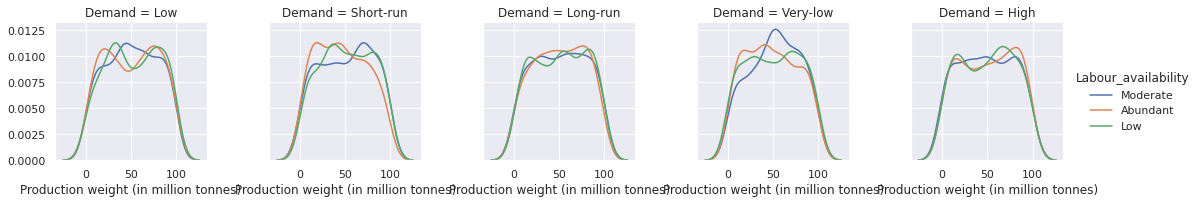

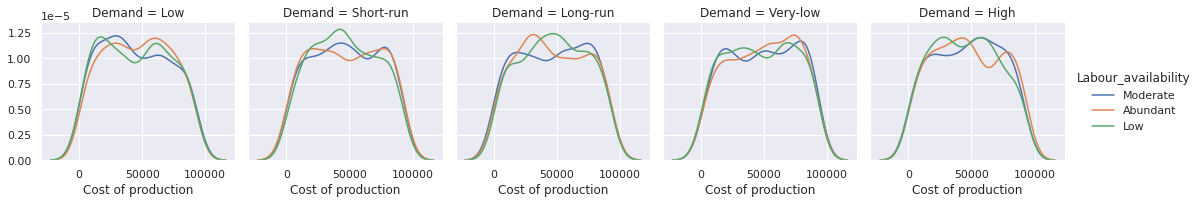

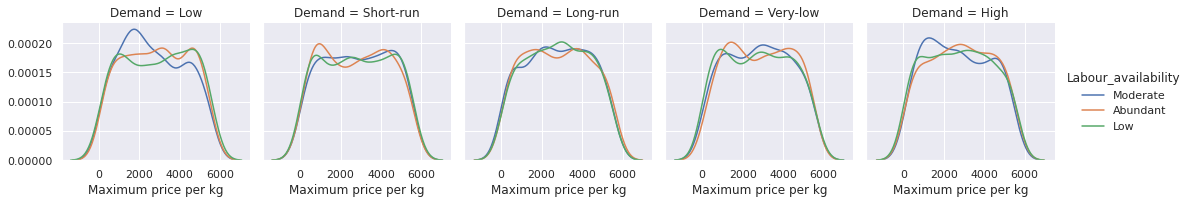

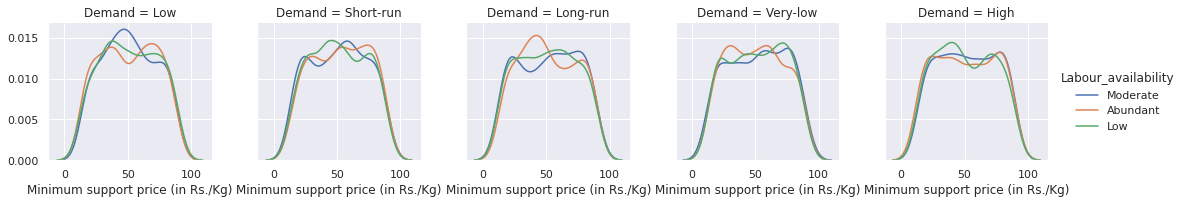

In [21]:
# KDE plot for train dataset with 5 condition of Demand and labour availability, numerical features 
for i in numerical_features:
    g = sns.FacetGrid(train_dataset, col="Demand", hue="Labour_availability")
    g.map(sns.kdeplot, i)
    g.add_legend()

In [ ]:
# for all unique dates, line plot of cost of production and MSP
g = sns.FacetGrid(train_dataset, col="Month-year", height=4)
sns_plot = g.map(sns.lineplot, "Cost of production"
, "Minimum support price (in Rs./Kg)")
(sns_plot.fig).savefig("min_cost_fig")


In [ ]:
# for all unique dates, line plot of cost of production and MSP, with hue of demand 

g = sns.FacetGrid(train_dataset, col="Month-year", height=4,hue="Demand")
sns_plot = g.map(sns.lineplot, "Cost of production"
, "Minimum support price (in Rs./Kg)")


In [ ]:

# (sns_plot.fig).legend()
sns_plot.add_legend()
(sns_plot.fig).savefig("min_cost_fig")


In [ ]:
df = train_dataset.groupby('CommodityID').mean()[numerical_features]
df = df.reset_index()

df.head(3)

In [ ]:

def rough_plot():
    df = train_dataset[["Month-year"]+numerical_features]
    date_time = pd.to_datetime(df.pop('Month-year'), format='%d.%m.%Y %H:%M:%S')

    df.index = date_time

    df.plot(subplots=True,figsize=(15,10))

    df[6000:].plot(subplots=True,figsize=(15,10))
    return df
df = rough_plot()

convert time to seconds

In [ ]:
def preprocess(train_dataset=train_dataset,normalize=False):
    import datetime
    
    timestamp_s = train_dataset['Month-year'].map(datetime.datetime.timestamp)
    train_dataset['Month-year']= timestamp_s

    column_indices = {name: i for i, name in enumerate(train_dataset.columns)}

    n = len(train_dataset)
    train_df = train_dataset[0:int(n*0.7)]
    val_df = train_dataset[int(n*0.7):int(n*0.9)]
    test_df = train_dataset[int(n*0.9):]

    num_features = train_dataset.shape[1]
    numerical_features
    train_df.shape,val_df.shape,test_df.shape
    if normalize:
        train_mean  =train_df[numerical_features].mean()
        train_std = train_df[numerical_features].std()
        train_df[numerical_features] = (train_df[numerical_features]-train_mean)/train_std
        test_df[numerical_features] = (test_df[numerical_features]-train_mean)/train_std
        val_df[numerical_features] = (val_df[numerical_features]-train_mean)/train_std
    return train_df,val_df,test_df

# 
train_df,val_df,test_df = preprocess()


In [ ]:
train_df.head(4)

In [31]:
train_dataset.index = train_dataset_copy['Month-year']
train_dataset.index

DatetimeIndex(['2012-01-01', '2012-01-01', '2012-01-01', '2012-01-01',
               '2012-01-01', '2012-01-01', '2012-01-01', '2012-01-01',
               '2012-01-01', '2012-01-01',
               ...
               '2020-12-01', '2020-12-01', '2020-12-01', '2020-12-01',
               '2020-12-01', '2020-12-01', '2020-12-01', '2020-12-01',
               '2020-12-01', '2020-12-01'],
              dtype='datetime64[ns]', name='Month-year', length=7000, freq=None)

In [32]:
y_msp = train_dataset['Minimum support price (in Rs./Kg)'].resample("MS").mean()
y_max = train_dataset['Maximum price per kg'].resample("MS").mean()
y_cost = train_dataset['Cost of production'].resample("MS").mean()

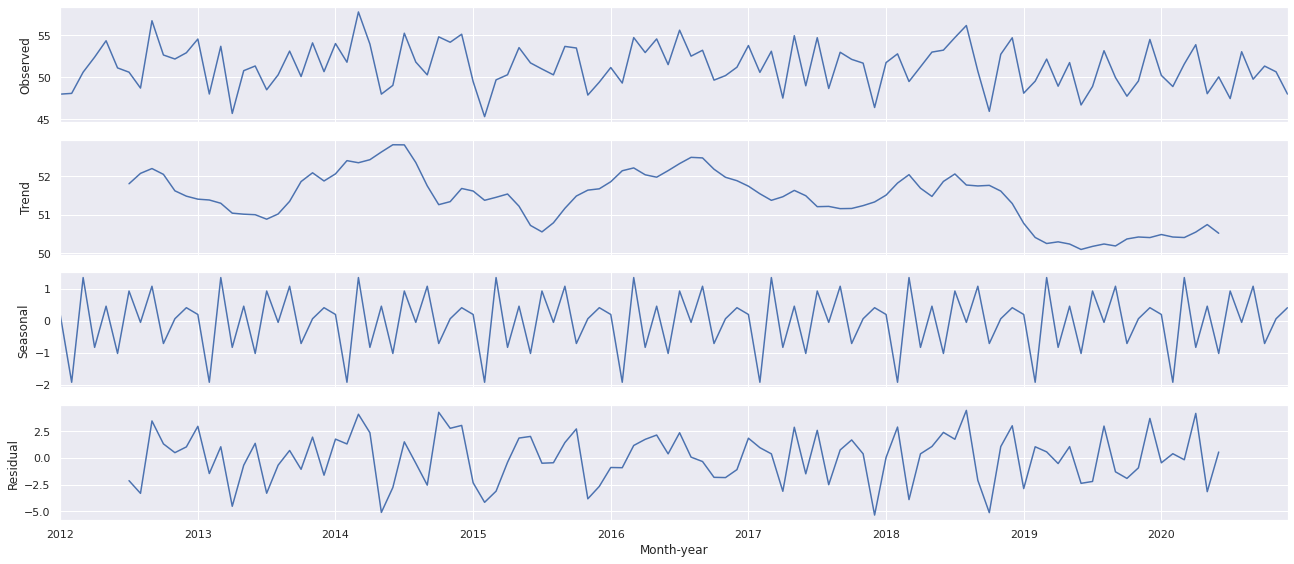

In [33]:
import statsmodels.api as sm

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_msp, model='additive')
fig = decomposition.plot()


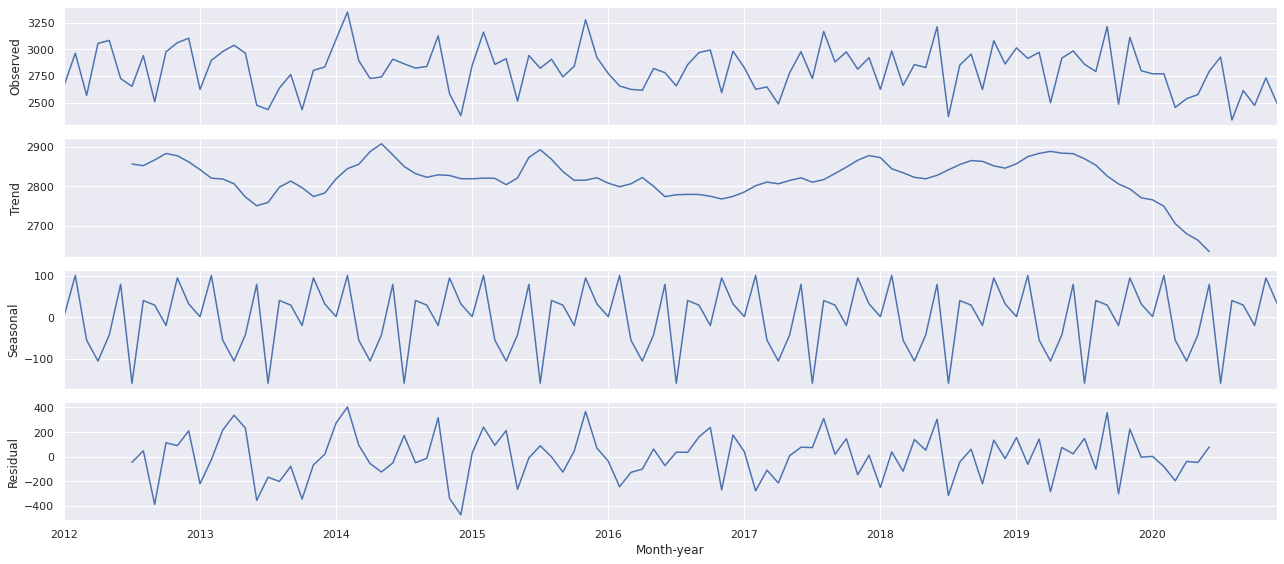

In [34]:
decomposition = sm.tsa.seasonal_decompose(y_max,model='additive')
fig = decomposition.plot()


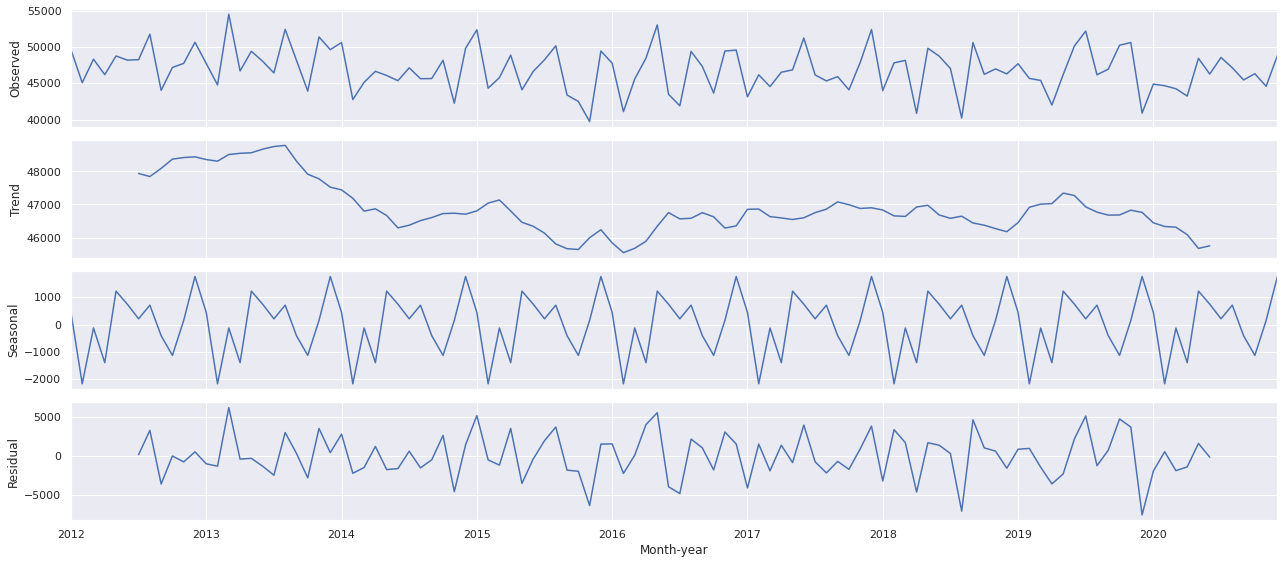

In [35]:
decomposition = sm.tsa.seasonal_decompose(y_cost, model='additive')
fig = decomposition.plot()


In [36]:
mod = sm.tsa.statespace.SARIMAX(y_msp,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0606      0.132      0.459      0.646      -0.198       0.319
ma.L1         -0.9703      0.064    -15.139      0.000      -1.096      -0.845
ar.S.L12      -0.5141      0.123     -4.191      0.000      -0.754      -0.274
sigma2        10.5182      1.819      5.782      0.000       6.953      14.084


In [37]:

mod = sm.tsa.statespace.SARIMAX(y_cost,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0804      0.156     -0.514      0.607      -0.387       0.226
ma.L1         -0.7604      0.091     -8.372      0.000      -0.938      -0.582
ar.S.L12      -0.2180      0.114     -1.917      0.055      -0.441       0.005
sigma2      1.918e+07    1.1e-09   1.74e+16      0.000    1.92e+07    1.92e+07


In [38]:
mod = sm.tsa.statespace.SARIMAX(y_max,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0463      0.119      0.390      0.697      -0.186       0.279
ma.L1         -0.9126      0.079    -11.487      0.000      -1.068      -0.757
ar.S.L12      -0.3555      0.098     -3.622      0.000      -0.548      -0.163
sigma2       7.14e+04   1.34e+04      5.341      0.000    4.52e+04    9.76e+04


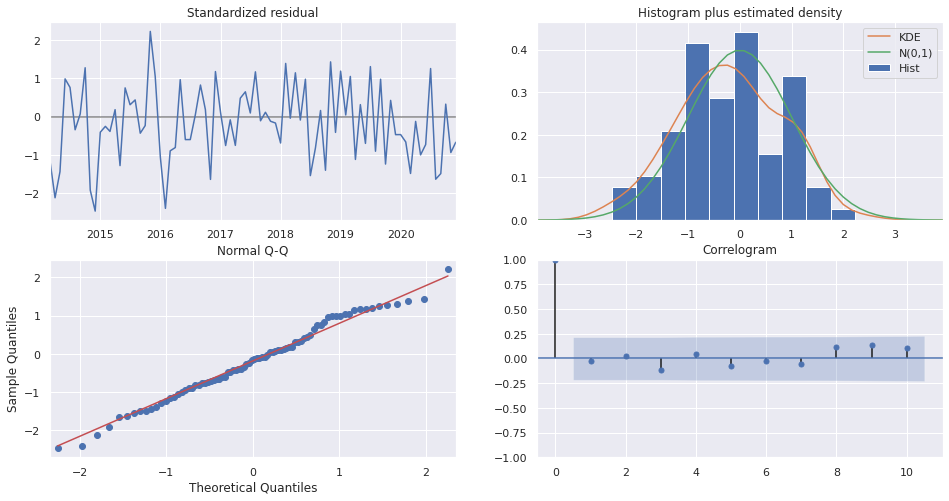

In [39]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

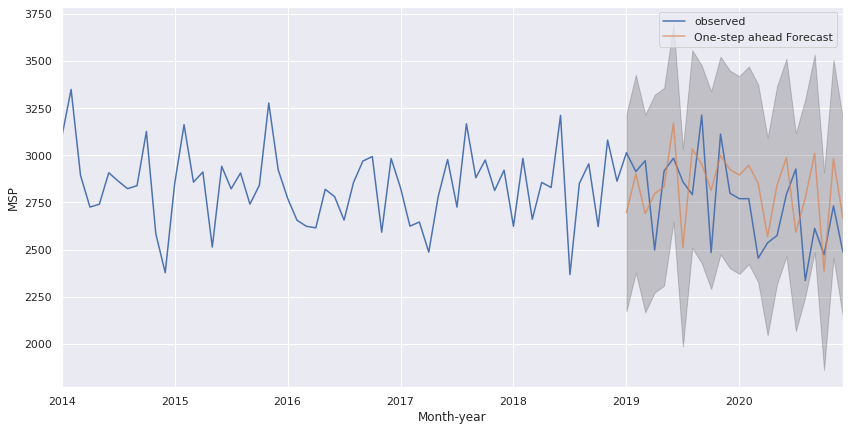

In [40]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y_max['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Month-year')
ax.set_ylabel('MSP')
plt.legend()
plt.show()

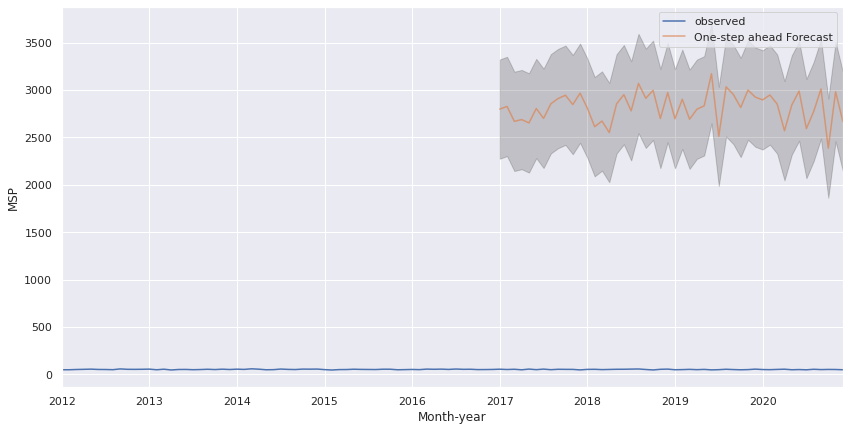

In [41]:
test_dataset['Month-year'].values.sort()

pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y_msp['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Month-year')
ax.set_ylabel('MSP')
plt.legend()
plt.show()

In [42]:
y_forecasted = pred.predicted_mean
y_truth = y_msp['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 7694014.04


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

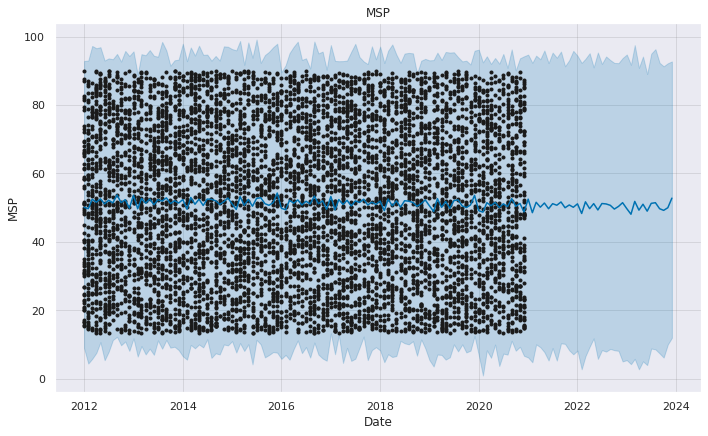

In [43]:
from fbprophet import Prophet


msp = train_dataset.rename(columns={'Month-year': 'ds', 'Minimum support price (in Rs./Kg)': 'y'})
msp_model = Prophet(interval_width=0.95)
msp_model.fit(msp)

max_ = train_dataset.rename(columns={'Month-year': 'ds', 'Maximum price per kg': 'y'})
max_model = Prophet(interval_width=0.95)
max_model.fit(max_)

msp_forecast = msp_model.make_future_dataframe(periods=36, freq='MS')
msp_forecast = msp_model.predict(msp_forecast)
max_forecast = max_model.make_future_dataframe(periods=36, freq='MS')
max_forecast = max_model.predict(max_forecast)
plt.figure(figsize=(18, 6))
msp_model.plot(msp_forecast, xlabel = 'Date', ylabel = 'MSP')
plt.title('MSP');

<Figure size 1296x432 with 0 Axes>

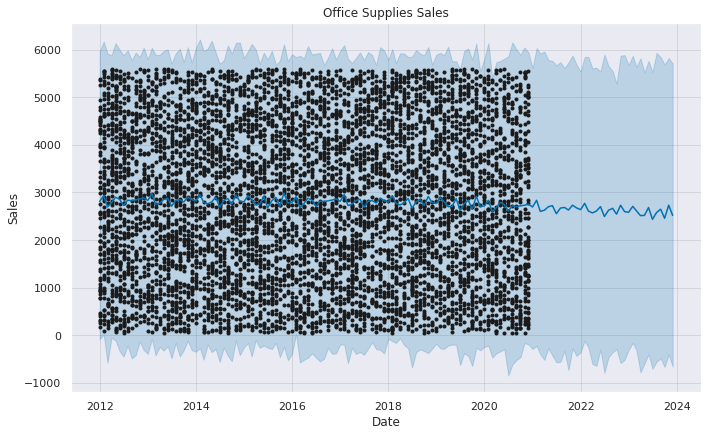

In [48]:
plt.figure(figsize=(18, 6))
max_model.plot(max_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

In [85]:
df = train_dataset.groupby('CommodityID').mean()[numerical_features]
df = df.reset_index()
df['name']= ''
for i in range(df.shape[0]):
    for id,name in zip(commodityID_dataset['CommodityID'].values,commodityID_dataset['Commodity_name'].values):
        if df.iloc[i]['CommodityID']==id:
            df['name'].iloc[i]= name

    # df.iloc[i]['CommodityID']



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [86]:
df

,CommodityID,Production weight (in million tonnes),Cost of production,Maximum price per kg,Minimum support price (in Rs./Kg),name
0,CD1,50.118182,54514.666667,2938.909091,51.450000,Paddy
1,CD10,48.209767,48211.441860,2760.325581,46.480465,Mung bean
2,CD100,50.469100,44749.370000,2717.460000,52.082900,Nigar Seed
3,CD101,55.530702,56214.543860,2598.877193,54.544561,Pongam seeds
4,CD102,53.346389,35527.305556,3364.444444,51.152222,Rapeseed
...,...,...,...,...,...,...
137,CD95,46.202195,44054.341463,2858.463415,49.344878,Iron ore
138,CD96,45.155536,48356.107143,2825.196429,52.762500,Copper concentrate
139,CD97,43.406200,51672.940000,2707.260000,51.795400,Cotton Seed
140,CD98,53.442889,53939.555556,2757.777778,54.850444,Kusum seed


In [102]:
test_dataset['Minimum support price (in Rs./Kg)'] = 0

for i in range(test_dataset.shape[0]):
    for price,name in zip(df['Minimum support price (in Rs./Kg)'],df['name']):
        if test_dataset['Commodity_name'].iloc[i]==name:
            test_dataset['Minimum support price (in Rs./Kg)'].iloc[i]= price

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [104]:
# test_dataset['Minimum support price (in Rs./Kg)'] = test_dataset['Minimum support price (in Rs./Kg)']*100

# test_dataset = test_dataset.rename(columns={'Minimum support price (in Rs./Kg)':"Minimum support price (in Rs./Quintal)"})
# test_dataset
test_dataset.to_csv("Test Data Prediction.csv")
